# E. Космическая стажировка

Вот и наступил ваш первый день на стажировке в космическом центре! Вас закинули на планету GREEN-N-55 на новейшем шатле, посадили за огромный компьютер и вручили униформу.
Ваш отдел занимается детекцией и классификацией космических кораблей. Коллеги уже сделали систему, которая засекает их приближение и распознает параметры корабля. Вам осталось лишь обучить классификатор, который предсказывает его класс с высокой точностью.
В папке лежит обучающий датасет (train.csv), и данные на которых нужно сделать предсказания (test.csv).
Так как цена ошибки очень высока, accuracy вашей модели должно быть не меньше 94%.
Вы должны загрузить в систему файл answers.csv, в каждой строке которого содержится одно число — 1 или 0 в зависимости от вашего предсказания.
Будет выведено - WA, если точность ниже 94% и OK, если выше.

## Шаг 1. Подготовка данных

Установим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import time

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(42)
RAND = 42

In [2]:
space_train_data = pd.read_csv('ml-task-cosmos/train.csv')
space_test_data = pd.read_csv('ml-task-cosmos/test.csv')

In [3]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        missing_data = (data.isna().mean() * 100).to_frame().rename(columns={0: 'space'}).query('space > 0')
        if not missing_data.empty:  # Проверка на наличие пропусков
            missing_data.sort_values(by='space', ascending=True).plot(kind='barh', figsize=(20, 10),
                                                                      legend=False, fontsize=10)
            plt.title('Пропущенные значения, %' + "\n", fontsize=22)
            print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
                  'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                       min(i for i in data.isna().sum() if i > 0),
                                                                       max(data.isna().sum()),
                                                                       min(i for i in data.isna().sum() if i > 0) / len(
                                                                           data),
                                                                       max(data.isna().sum()) / len(data),
                                                                       (data.isna().sum(axis=0) > 0).sum()
                                                                       ))
        else:
            print('пропусков не нашлось :) ')
    except Exception as e:
        print('Ошибка при обработке данных:', str(e))

In [4]:
# Функция изучения данных в таблице
def research_info(data, name):
    rows_count, columns_count = data.shape
    print('Данные {}'.format(name))
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    data.info()
    display(data.sample(n=5))
    display(data.describe())
    pass_value_barh(data)

In [5]:
research_info(space_train_data, 'train')

Данные train
Количество стобцов: 17
Количество строк: 1288
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           1288 non-null   int64  
 1   perimeter      1288 non-null   float64
 2   major_axis     1288 non-null   float64
 3   minor_axis     1288 non-null   float64
 4   eccentricity   1288 non-null   float64
 5   eqdiasq        1288 non-null   float64
 6   solidity       1288 non-null   float64
 7   convex_area    1288 non-null   int64  
 8   extent         1288 non-null   float64
 9   aspect_ratio   1288 non-null   float64
 10  roundness      1288 non-null   float64
 11  compactness    1288 non-null   float64
 12  shapefactor_1  1288 non-null   float64
 13  shapefactor_2  1288 non-null   float64
 14  shapefactor_3  1288 non-null   float64
 15  shapefactor_4  1288 non-null   float64
 16  target         1288 non

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
51,69286,1065.2770,388.9586,228.6601,0.8089,297.0146,0.9773,70896,0.7520,1.7010,0.7672,0.7636,0.0056,0.0033,0.5831,0.9919,0
232,82341,1140.2820,457.2149,230.3999,0.8638,323.7898,0.9882,83328,0.7497,1.9844,0.7958,0.7082,0.0056,0.0028,0.5015,0.9952,1
573,87051,1207.6090,425.2940,275.8212,0.7612,332.9216,0.9368,92926,0.6308,1.5419,0.7501,0.7828,0.0049,0.0032,0.6128,0.9449,0
607,76093,1138.8781,424.5136,244.2908,0.8178,311.2629,0.9335,81516,0.6189,1.7377,0.7372,0.7332,0.0056,0.0032,0.5376,0.9342,0
133,92631,1260.7520,468.0538,255.6497,0.8377,343.4261,0.9791,94609,0.7977,1.8308,0.7323,0.7337,0.0051,0.0028,0.5384,0.9857,0


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
count,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000
mean,80192.842391,1424.132159,446.736247,238.849535,0.839789,318.462997,0.940446,85271.466615,0.715694,1.895493,0.570942,0.713565,0.005681,0.003012,0.511055,0.955463,0.572205
std,12890.918654,374.379140,32.068318,30.088275,0.049087,26.202102,0.048665,13041.212252,0.051630,0.237825,0.210716,0.043375,0.000751,0.000332,0.062514,0.050770,0.494951
min,37130.000000,858.363000,321.425500,135.694900,0.504900,217.429000,0.680200,41290.000000,0.500300,1.158500,0.122000,0.564900,0.004000,0.002400,0.319100,0.641400,0.000000
25%,71986.250000,1170.996250,427.447800,217.952075,0.816675,302.747000,0.921400,76696.500000,0.687750,1.732925,0.376150,0.681850,0.005100,0.002800,0.464950,0.944300,0.000000
50%,79785.000000,1264.054000,449.098750,236.574350,0.848750,318.724700,0.953400,85075.500000,0.725250,1.891150,0.642900,0.711000,0.005600,0.002950,0.505550,0.972900,1.000000
75%,89538.750000,1601.925750,468.282275,258.349475,0.875300,337.645200,0.976025,93987.500000,0.752925,2.067750,0.743100,0.742425,0.006100,0.003200,0.551250,0.986800,1.000000
max,124008.000000,2755.049100,535.642200,383.046100,0.945400,397.356100,0.994800,132478.000000,0.820400,3.069300,0.933600,0.869500,0.010000,0.005300,0.756100,0.998900,1.000000


пропусков не нашлось :) 


interval columns not set, guessing: ['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'eqdiasq', 'solidity', 'convex_area', 'extent', 'aspect_ratio', 'roundness', 'compactness', 'shapefactor_1', 'shapefactor_2', 'shapefactor_3', 'shapefactor_4', 'target']


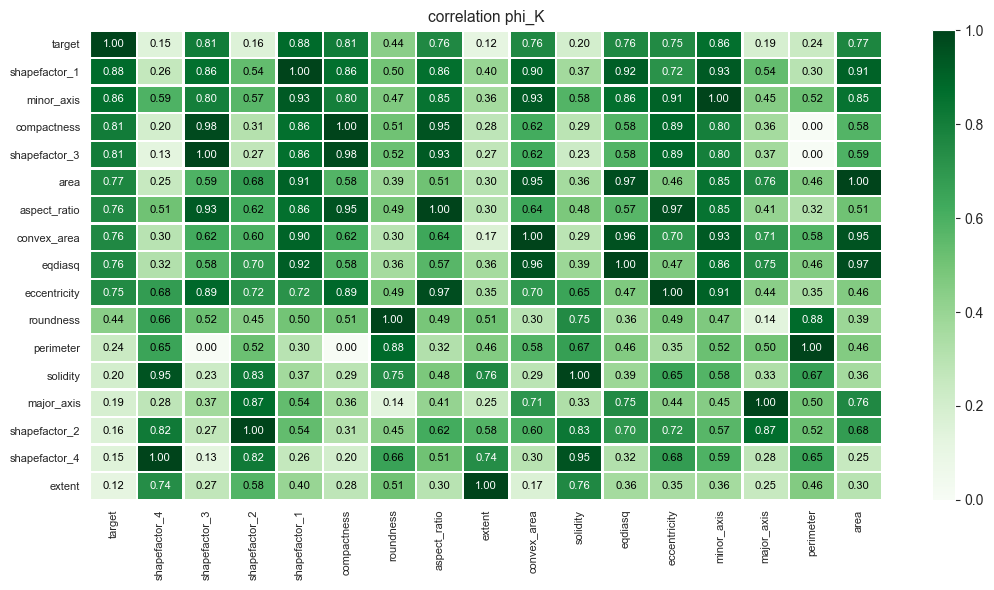

In [6]:
phik_overview = space_train_data.phik_matrix().round(2).sort_values('target')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation phi_K", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [7]:
research_info(space_test_data, 'test')

Данные test
Количество стобцов: 16
Количество строк: 430
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           430 non-null    int64  
 1   perimeter      430 non-null    float64
 2   major_axis     430 non-null    float64
 3   minor_axis     430 non-null    float64
 4   eccentricity   430 non-null    float64
 5   eqdiasq        430 non-null    float64
 6   solidity       430 non-null    float64
 7   convex_area    430 non-null    int64  
 8   extent         430 non-null    float64
 9   aspect_ratio   430 non-null    float64
 10  roundness      430 non-null    float64
 11  compactness    430 non-null    float64
 12  shapefactor_1  430 non-null    float64
 13  shapefactor_2  430 non-null    float64
 14  shapefactor_3  430 non-null    float64
 15  shapefactor_4  430 non-null    float64
dtypes: float64(14), int64(2)
me

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
400,93975,1313.6740,480.2703,251.2122,0.8523,345.9085,0.9787,96016,0.7020,1.9118,0.6843,0.7202,0.0051,0.0027,0.5187,0.9917
362,85969,2345.6279,421.6958,291.1149,0.7235,330.8461,0.8702,98789,0.7033,1.4486,0.1964,0.7846,0.0049,0.0034,0.6155,0.8916
291,100292,1265.0770,457.1541,285.5709,0.7809,357.3454,0.9634,104098,0.7505,1.6008,0.7875,0.7817,0.0046,0.0028,0.6110,0.9781
98,83617,1148.6021,456.7517,233.5336,0.8594,326.2889,0.9904,84428,0.7775,1.9558,0.7965,0.7144,0.0055,0.0028,0.5103,0.9981
82,60324,1851.1190,367.9640,216.4043,0.8088,277.1406,0.9038,66748,0.7151,1.7004,0.2212,0.7532,0.0061,0.0036,0.5673,0.9646


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,78910.776744,1414.804734,444.619500,236.226961,0.842020,315.774141,0.939074,83977.790698,0.717134,1.910872,0.570500,0.710671,0.005774,0.003032,0.507227,0.954354
std,13165.413584,370.832918,31.314031,31.371180,0.048863,27.582299,0.053871,13170.025627,0.055202,0.251173,0.214135,0.046682,0.000963,0.000343,0.065942,0.054575
min,29808.000000,962.101000,326.205900,133.509600,0.621700,194.814600,0.588000,37935.000000,0.427200,1.276700,0.062800,0.476000,0.004000,0.002500,0.226600,0.620400
25%,71277.750000,1160.388475,425.908125,217.461150,0.819425,301.253475,0.918250,75594.250000,0.689275,1.744600,0.342750,0.683025,0.005200,0.002800,0.466525,0.942825
50%,79841.500000,1251.349100,446.945150,233.377200,0.852700,318.837500,0.954700,84560.500000,0.730200,1.914200,0.647600,0.707050,0.005700,0.003000,0.499900,0.972700
75%,87944.750000,1584.138750,466.108300,255.401500,0.875850,334.626225,0.977675,92619.000000,0.756950,2.072175,0.751750,0.737625,0.006100,0.003200,0.544150,0.987300
max,113794.000000,2656.782000,508.133900,334.997800,0.946000,380.640300,0.995100,122368.000000,0.808300,3.085800,0.893800,0.851100,0.013100,0.004800,0.724400,0.999000


пропусков не нашлось :) 


In [8]:
space_train_data['target'] = space_train_data['target'].astype(bool)

## Шаг 2. Работа с моделями

Разделим данные на features и target, а так же разобьем на трейн и тест

In [9]:
features = space_train_data.drop('target', axis=1)
target = space_train_data['target']

In [10]:
target.dtype

dtype('bool')

In [11]:
# Проверка на дисбаланс
target.value_counts(normalize=True)

target
True     0.572205
False    0.427795
Name: proportion, dtype: float64

In [12]:
# features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2,
#                                                                             random_state=RANDOM_VAL)

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_VAL)
features_train_, features_val, target_train_, target_val = train_test_split(features_train,
                                                                            target_train,
                                                                            test_size=0.16,
                                                                            random_state=RANDOM_VAL)
eval_set = [(features_val, target_val)]

Создадим функции, которые позволят сравнить в конце все модели и следить за качеством по ходу работы.

In [14]:
# Генерация таблицы с метриками
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                name: str = None,
                time_fit: str = None,
                time_pred: str = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['Time fit'] = time_fit
    df_metrics['Time pred'] = time_pred

    return df_metrics

In [15]:
# Проверка на переобучение
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test) / mae_train * 100):.1f} %')

### 2.1 LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
time_start_fit = time.time()
lr.fit(features_train_, target_train_)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_lr = lr.predict(features_val)
time_spent_pred = time.time() - time_start_pred

metrics = get_metrics(target_val, target_pred_lr, 'LogisticRegression', time_spent_fit, time_spent_pred)

### 2.2 DecisionTreeClassifier

In [17]:
dtc = DecisionTreeClassifier(random_state=RANDOM_VAL)

time_start_fit = time.time()
dtc.fit(features_train_, target_train_)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_dtc = dtc.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [18]:
metrics = metrics._append(get_metrics(target_val, target_pred_dtc, 'DecisionTreeClassifier', time_spent_fit, time_spent_pred))

### 2.3 RandomForestClassifier

К сожалению, модель случайного леса рассчитывается очень долго, поэтому исключим её из исследования.

In [19]:
rfc = RandomForestClassifier(random_state=RANDOM_VAL)

time_start_fit = time.time()
rfc.fit(features_train_, target_train_)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_rfc = rfc.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [20]:
metrics = metrics._append(
    get_metrics(target_val, target_pred_rfc, 'RandomForestClassifier', time_spent_fit, time_spent_pred))

### 2.4 LGBMClassifier

In [21]:
lgb = LGBMClassifier(random_state=RAND)

time_start_fit = time.time()
lgb.fit(features_train_,
        target_train_,
        eval_metric="",
        eval_set=eval_set,
        # verbose=False,
        # early_stopping_rounds=100
        )
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_lgb = lgb.predict(features_val)
time_spent_pred = time.time() - time_start_pred

[LightGBM] [Info] Number of positive: 495, number of negative: 370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572254 -> initscore=0.291055
[LightGBM] [Info] Start training from score 0.291055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [22]:
metrics = metrics._append(
    get_metrics(target_val, target_pred_lgb, 'LGBMClassifier', time_spent_fit, time_spent_pred))

### 2.5 CatBoostClassifier

In [23]:
cbc = CatBoostClassifier(random_seed=RAND,
                         allow_writing_files=False)

time_start_fit = time.time()
cbc.fit(features_train_,
        target_train_,
        eval_set=eval_set,
        verbose=0,
        early_stopping_rounds=100)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_cbc = cbc.predict(features_val)
time_spent_pred = time.time() - time_start_pred


In [24]:
target_pred_cbc = target_pred_cbc.astype(target_val.dtype)

In [25]:
metrics = metrics._append(
    get_metrics(target_val, target_pred_cbc, 'CatBoostClassifier', time_spent_fit, time_spent_pred))

### 2.7 DummyClassifier

In [26]:
dc = DummyClassifier(random_state=RANDOM_VAL)

time_start_fit = time.time()
dc.fit(features_train_, target_train_)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_dc = dc.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [27]:
metrics = metrics._append(
    get_metrics(target_val, target_pred_dc, 'DummyClassifier', time_spent_fit, time_spent_pred))

## Шаг 3. Подготовка тестовой выборки


In [28]:
research_info(space_test_data, 'test')

Данные test
Количество стобцов: 16
Количество строк: 430
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           430 non-null    int64  
 1   perimeter      430 non-null    float64
 2   major_axis     430 non-null    float64
 3   minor_axis     430 non-null    float64
 4   eccentricity   430 non-null    float64
 5   eqdiasq        430 non-null    float64
 6   solidity       430 non-null    float64
 7   convex_area    430 non-null    int64  
 8   extent         430 non-null    float64
 9   aspect_ratio   430 non-null    float64
 10  roundness      430 non-null    float64
 11  compactness    430 non-null    float64
 12  shapefactor_1  430 non-null    float64
 13  shapefactor_2  430 non-null    float64
 14  shapefactor_3  430 non-null    float64
 15  shapefactor_4  430 non-null    float64
dtypes: float64(14), int64(2)
me

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
28,87997,1316.5439,461.6088,263.9095,0.8205,334.7256,0.9152,96152,0.6706,1.7491,0.6380,0.7251,0.0052,0.0030,0.5258,0.9197
147,61137,1517.4890,392.1009,212.6747,0.8401,279.0019,0.9021,67771,0.6920,1.8437,0.3336,0.7116,0.0064,0.0035,0.5063,0.9335
427,85519,1200.8210,480.6819,240.4698,0.8659,329.9790,0.9254,92409,0.7129,1.9989,0.7453,0.6865,0.0056,0.0028,0.4713,0.9420
91,85638,2086.7080,456.2328,269.5458,0.8068,330.2086,0.8701,98419,0.6810,1.6926,0.2471,0.7238,0.0053,0.0031,0.5238,0.8867
41,59875,1236.7390,392.9745,200.6802,0.8598,276.1073,0.9410,63631,0.7252,1.9582,0.4919,0.7026,0.0066,0.0034,0.4937,0.9667


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,78910.776744,1414.804734,444.619500,236.226961,0.842020,315.774141,0.939074,83977.790698,0.717134,1.910872,0.570500,0.710671,0.005774,0.003032,0.507227,0.954354
std,13165.413584,370.832918,31.314031,31.371180,0.048863,27.582299,0.053871,13170.025627,0.055202,0.251173,0.214135,0.046682,0.000963,0.000343,0.065942,0.054575
min,29808.000000,962.101000,326.205900,133.509600,0.621700,194.814600,0.588000,37935.000000,0.427200,1.276700,0.062800,0.476000,0.004000,0.002500,0.226600,0.620400
25%,71277.750000,1160.388475,425.908125,217.461150,0.819425,301.253475,0.918250,75594.250000,0.689275,1.744600,0.342750,0.683025,0.005200,0.002800,0.466525,0.942825
50%,79841.500000,1251.349100,446.945150,233.377200,0.852700,318.837500,0.954700,84560.500000,0.730200,1.914200,0.647600,0.707050,0.005700,0.003000,0.499900,0.972700
75%,87944.750000,1584.138750,466.108300,255.401500,0.875850,334.626225,0.977675,92619.000000,0.756950,2.072175,0.751750,0.737625,0.006100,0.003200,0.544150,0.987300
max,113794.000000,2656.782000,508.133900,334.997800,0.946000,380.640300,0.995100,122368.000000,0.808300,3.085800,0.893800,0.851100,0.013100,0.004800,0.724400,0.999000


пропусков не нашлось :) 


Данные готовы к обучению.

## Шаг 4. Вывод решения


In [29]:
metrics

,model,accuracy,Time fit,Time pred
0,LogisticRegression,0.830303,0.049999,0.002000
0,DecisionTreeClassifier,0.824242,0.026000,0.001000
0,RandomForestClassifier,0.818182,0.407124,0.004999
0,LGBMClassifier,0.830303,0.119193,0.002000
0,CatBoostClassifier,0.606061,0.936406,0.002000
0,DummyClassifier,0.606061,0.000000,0.000000


In [30]:
best_model = rfc
predictions = best_model.predict(space_test_data)
predictions = pd.DataFrame(predictions.astype(int), columns=['target'])
predictions.to_csv(f"answer_1.csv", index=False)

In [31]:
# Создаем новый датафрейм для блендинга предсказаний
blended_predictions = pd.DataFrame()

# Добавляем предсказания каждой модели в новый датафрейм
blended_predictions['model_1'] = lr.predict(space_test_data)
# blended_predictions['model_2'] = rfc.predict(space_test_data)
blended_predictions['model_3'] = lgb.predict(space_test_data)

# Вычисляем среднее значение предсказаний каждой строки
blended_predictions['final_prediction'] = blended_predictions.mean(axis=1)

blended_predictions['final_prediction'].astype(int).to_csv('blended_predictions_2.csv', index=False, index_label=False)